In [5]:
# Importing Necessary Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
import yellowbrick as yb
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [6]:
# Initialize Plotly for use in the notebook offline

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [8]:
# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

In [9]:
# Preliminary analysis to understand the structure and types of data columns

df_retail = pd.read_csv("Online Retail.csv")
df_retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 8:34,1.69,13047.0,United Kingdom


In [10]:
df_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [11]:
# Summary statistics for numerical variables
df_retail.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [12]:
# Summary statistics for categorical variables
df_retail.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,2011-10-31 14:41,1114
Country,541909,38,United Kingdom,495478


# Inferences:
1. Quantity:
The average quantity of products in a transaction is approximately 9.55.
The quantity has a wide range, with a minimum value of -80995 and a maximum value of 80995. The negative values indicate returned or cancelled orders, which need to be handled appropriately.
The standard deviation is quite large, indicating a significant spread in the data. The presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.
2. UnitPrice:
The average unit price of the products is approximately 4.61.
The unit price also shows a wide range, from -11062.06 to 38970, which suggests the presence of errors or noise in the data, as negative prices don't make sense.
Similar to the Quantity column, the presence of outliers is indicated by a large difference between the maximum and the 75th percentile values.
3. CustomerID:
There are 406829 non-null entries, indicating missing values in the dataset which need to be addressed.
The Customer IDs range from 12346 to 18287, helping in identifying unique customers.
4. InvoiceNo:
There are 25900 unique invoice numbers, indicating 25900 separate transactions.
The most frequent invoice number is 573585, appearing 1114 times, possibly representing a large transaction or an order with multiple items.
5. StockCode:
There are 4070 unique stock codes representing different products.
The most frequent stock code is 85123A, appearing 2313 times in the dataset.
6. Description:
There are 4223 unique product descriptions.
The most frequent product description is "WHITE HANGING HEART T-LIGHT HOLDER", appearing 2369 times.
There are some missing values in this column which need to be treated.
7.untry:
The transactions come from 38 different countries, with a dominant majority of the transactions (approximately 91.4%) originating from the United Kingdom.

In [13]:
# Handling Missing Values
missing_data = df_retail.isnull().sum()
missing_data

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [14]:
# As we can see, there's missing data in Column 'Description' and 'CustomerID' like we discussed above.
# To see the percentage of data missing
missing_percentage = (missing_data[missing_data > 0] / df_retail.shape[0]) * 100
missing_percentage.sort_values(ascending=True, inplace=True)
missing_percentage

Description     0.268311
CustomerID     24.926694
dtype: float64


### CustomerID (24.93% missing values)

The CustomerID column contains nearly a quarter of missing data. This column is essential for clustering customers and creating a recommendation system. Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis.

Moreover, since the clustering is based on customer behavior and preferences, it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing CustomerIDs seems to be the most reasonable approach to maintain the integrity of the clusters and the analysis.

### Description (0.27% missing values)

The Description column has a minor percentage of missing values. However, it has been noticed that there are inconsistencies in the data where the same StockCode does not always have the same Description (unique number is different). This indicates data quality issues and potential errors in the product descriptions.

Given these inconsistencies, imputing the missing descriptions based on StockCode might not be reliable. Moreover, since the missing percentage is quite low, it would be prudent to remove the rows with missing Descriptions to avoid propagating errors and inconsistencies into the subsequent analyses.

By removing rows with missing values in the CustomerID and Description columns, we aim to construct a cleaner and more reliable dataset, which is essential for achieving accurate clustering and creating an effective recommendation system.


In [15]:
# Extracting rows with missing values in 'CustomerID' or 'Description' columns
df_retail[df_retail['CustomerID'].isnull() | df_retail['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32,1.66,NaN,United Kingdom


In [16]:
# Removing rows with missing values in 'CustomerID' and 'Description' columns
df_retail = df_retail.dropna(subset=['CustomerID', 'Description'])
df_retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50,4.15,12680.0,France


In [14]:
# Verifying the removal of missing values
df_retail.isnull().sum().sum()

0

In [18]:
# Handling Duplicates
# Finding duplicate rows (keeping all instances)
duplicate_rows = df_retail[df_retail.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Displaying the first 10 records
duplicate_rows_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10062 entries, 494 to 529981
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    10062 non-null  object 
 1   StockCode    10062 non-null  object 
 2   Description  10062 non-null  object 
 3   Quantity     10062 non-null  int64  
 4   InvoiceDate  10062 non-null  object 
 5   UnitPrice    10062 non-null  float64
 6   CustomerID   10062 non-null  float64
 7   Country      10062 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 707.5+ KB


## Handling Duplicates Strategy:
In the context of this project, the presence of completely identical rows, including identical transaction times, suggests that these might be data recording errors rather than genuine repeated transactions. 
Keeping these duplicate rows can introduce noise and potential inaccuracies in the clustering and recommendation system.

Therefore, I am going to remove these completely identical duplicate rows from the dataset. 
Removing these rows will help in achieving a cleaner dataset, which in turn would aid in building more accurate customer clusters based on their unique purchasing behaviors.
Moreover, it would help in creating a more precise recommendation system by correctly identifying the products with the most purchases.

In [19]:
# Displaying the number of duplicate rows
print(f"The dataset contains {df_retail.duplicated().sum()} duplicate rows that need to be removed.")

# Removing duplicate rows
df_retail.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [20]:
# Checking the duplicate by row number
df_retail.iloc[517]

InvoiceNo                                536409
StockCode                                 21326
Description    AGED GLASS SILVER T-LIGHT HOLDER
Quantity                                     12
InvoiceDate                    2010-12-01 11:45
UnitPrice                                  0.65
CustomerID                              17908.0
Country                          United Kingdom
Name: 518, dtype: object

In [21]:
# Getting the number of rows in the dataframe
df_retail.shape[0]

401604

In [23]:
# Deal with canceled transactions, InvoiceNo starts with C
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df_retail['Transaction_Status'] = np.where(df_retail['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df_retail[df_retail['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


## Strategy for Handling Cancelled Transactions:
Considering the project's objective to cluster customers based on their purchasing behavior and preferences and to eventually create a recommendation system, it's imperative to understand the cancellation patterns of customers. 
Therefore, the strategy is to retain these cancelled transactions in the dataset, marking them distinctly to facilitate further analysis. 

This approach will:
Enhance the clustering process by incorporating patterns and trends observed in cancellation data,
which might represent certain customer behaviors or preferences.
Allow the recommendation system to possibly prevent suggesting products that have a high likelihood of being cancelled,
thereby improving the quality of recommendations.

In [24]:
df_retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,Completed
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50,0.85,12680.0,France,Completed
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50,2.10,12680.0,France,Completed
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50,4.15,12680.0,France,Completed
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50,4.15,12680.0,France,Completed


In [25]:
cancelled_transactions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
141,C536379,D,Discount,-1,2010-12-01 9:41,27.50,14527.0,United Kingdom,Cancelled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 9:49,4.65,15311.0,United Kingdom,Cancelled
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24,1.65,17548.0,United Kingdom,Cancelled
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24,0.29,17548.0,United Kingdom,Cancelled
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24,0.29,17548.0,United Kingdom,Cancelled
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 9:57,0.83,14397.0,United Kingdom,Cancelled
541541,C581499,M,Manual,-1,2011-12-09 10:28,224.69,15498.0,United Kingdom,Cancelled
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57,10.95,15311.0,United Kingdom,Cancelled
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58,1.25,17315.0,United Kingdom,Cancelled


In [26]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df_retail.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.21%


## Dealing with Anomalies

In [27]:
# Correcting StockCode Anomalies
# Finding the number of unique stock codes
unique_stock_codes = df_retail['StockCode'].nunique()

# Printing the number of unique stock codes
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


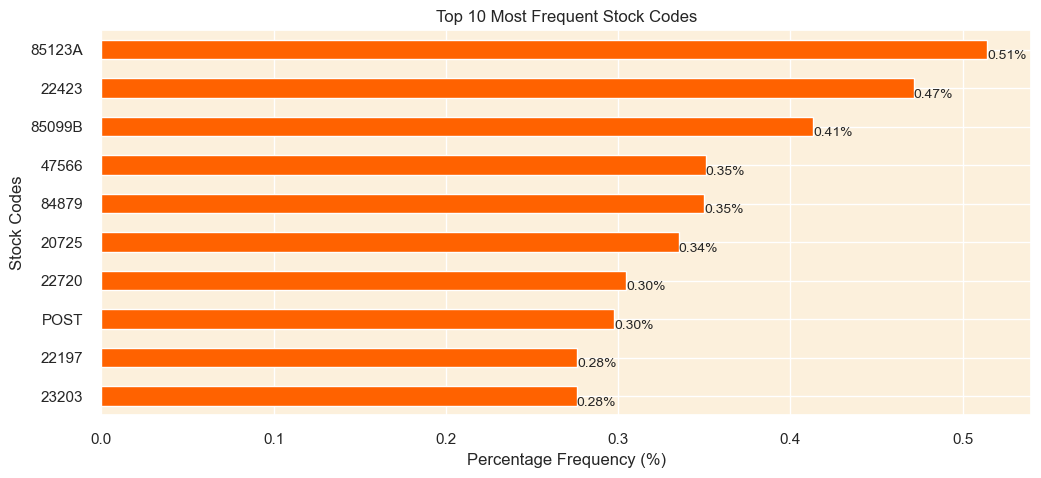

In [28]:
# Finding the top 10 most frequent stock codes
top_10_stock_codes = df_retail['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

### Inferences on Stock Codes:
1. Product Variety: The dataset contains 3684 unique stock codes, indicating a substantial variety of products available in the online retail store. This diversity can potentially lead to the identification of distinct customer clusters, with preferences for different types of products.
Popular Items: A closer look at the top 10 most frequent stock codes can offer insights into the popular products or categories that are frequently purchased by customers.
2. Stock Code Anomalies: We observe that while most stock codes are composed of 5 or 6 characters, there are some anomalies like the code 'POST'. These anomalies might represent services or non-product transactions (perhaps postage fees) rather than actual products. To maintain the focus of the project, which is clustering based on product purchases and creating a recommendation system, these anomalies should be further investigated and possibly treated appropriately to ensure data integrity.

In [29]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df_retail['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

In [30]:
# Printing the value counts for unique stock codes
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


### The output indicates the following:

A majority of the unique stock codes (3676 out of 3684) contain exactly 5 numeric characters, which seems to be the standard format for representing product codes in this dataset.
There are a few anomalies: 7 stock codes contain no numeric characters and 1 stock code contains only 1 numeric character. These are clearly deviating from the standard format and need further investigation to understand their nature and whether they represent valid product transactions.
Now, let's identify the stock codes that contain 0 or 1 numeric characters to further understand these anomalies:

In [31]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [32]:
# Calculating the percentage of records with these stock codes
percentage_anomalous = (df_retail['StockCode'].isin(anomalous_stock_codes).sum() / len(df_retail)) * 100

# Printing the percentage
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


### Inference: 
Based on the analysis, we find that a very small proportion of the records, 0.48%, have anomalous stock codes, which deviate from the typical format observed in the majority of the data. Also, these anomalous codes are just a fraction among all unique stock codes (only 8 out of 3684).

These codes seem to represent non-product transactions like "BANK CHARGES", "POST" (possibly postage fees), etc. Since they do not represent actual products and are a very small proportion of the dataset, including them in the analysis might introduce noise and distort the clustering and recommendation system.

### Strategy:
Given the context of the project, where the aim is to cluster customers based on their product purchasing behaviors and develop a product recommendation system, it would be prudent to exclude these records with anomalous stock codes from the dataset. This way, the focus remains strictly on genuine product transactions, which would lead to a more accurate and meaningful analysis.

In [33]:
# Removing rows with anomalous stock codes from the dataset
df_retail = df_retail[~df_retail['StockCode'].isin(anomalous_stock_codes)]

In [34]:
df_retail.shape[0]

399689

### Cleaning Description Column

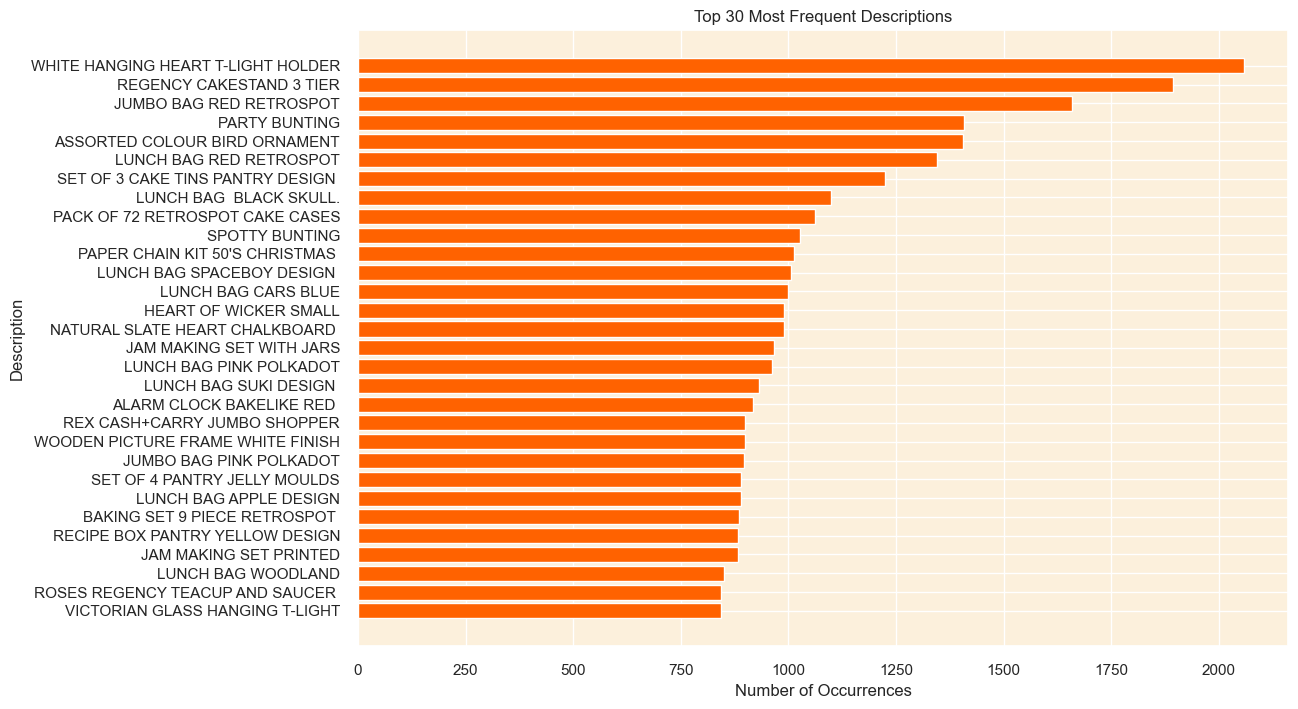

In [35]:
# Calculate the occurrence of each unique description and sort them
description_counts = df_retail['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts.head(30) # description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

The most frequent descriptions are generally household items, particularly those associated with kitchenware, lunch bags, and decorative items.
Interestingly, all the descriptions are in uppercase, which might be a standardized format for entering product descriptions in the database. However, considering the inconsistencies and anomalies encountered in the dataset so far, it would be prudent to check if there are descriptions entered in lowercase or a mix of case styles.

In [33]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df_retail['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


Upon reviewing the descriptions that contain lowercase characters, it is evident that some entries are not product descriptions, such as "Next Day Carriage" and "High Resolution Image". These entries seem to be unrelated to the actual products and might represent other types of information or service details.

### Strategy:
*  Remove the rows where the descriptions contain service-related information like "Next Day Carriage" and "High Resolution Image", as these do not represent actual products and would not contribute to the clustering and recommendation system we aim to build

* : For the remaining descriptions with mixed case, standardize the text to uppercase to maintain uniformity across the dataset. This will also assist in reducing the chances of having duplicate entries with different case styles
.
By implementing the above strategy, we can enhance the quality of our dataset, making it more suitable for the analysis and modeling phases of our project.

In [36]:
service_related_descriptions = df_retail[df_retail['Description'].isin(["Next Day Carriage", "High Resolution Image"])]
service_related_descriptions

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
205748,554835,23444,Next Day Carriage,1,2011-05-26 16:11,15.0,15241.0,United Kingdom,Completed
209588,555251,23444,Next Day Carriage,1,2011-06-01 15:12,15.0,13062.0,United Kingdom,Completed
210691,555312,23444,Next Day Carriage,1,2011-06-02 10:39,15.0,16484.0,United Kingdom,Completed
211341,555367,23444,Next Day Carriage,1,2011-06-02 14:28,15.0,17900.0,United Kingdom,Completed
218011,555948,23444,Next Day Carriage,1,2011-06-08 10:49,30.0,13752.0,United Kingdom,Completed
...,...,...,...,...,...,...,...,...,...
525425,580622,23444,Next Day Carriage,1,2011-12-05 12:09,15.0,17006.0,United Kingdom,Completed
525438,580630,23444,Next Day Carriage,1,2011-12-05 12:11,15.0,12913.0,United Kingdom,Completed
534091,581132,23444,Next Day Carriage,1,2011-12-07 12:55,15.0,17590.0,United Kingdom,Completed
536863,581221,23444,Next Day Carriage,1,2011-12-08 9:40,15.0,17856.0,United Kingdom,Completed


In [37]:
# Calculate the percentage of records with service-related descriptions
service_related_percentage = service_related_descriptions.shape[0] / df_retail.shape[0] * 100

# Print the percentage of records with service-related descriptions
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [38]:
# Remove rows with service-related information in the description
df_retail = df_retail[~df_retail['Description'].isin(["Next Day Carriage", "High Resolution Image"])]

# Standardize the text to uppercase to maintain uniformity across the dataset
df_retail['Description'] = df_retail['Description'].str.upper()
df_retail['Description'].shape[0]

399606

### Treating Zero Unit Prices

In [37]:
df_retail['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error. To understand their nature, it is essential to investigate these zero unit price transactions further. A detailed analysis of the product descriptions associated with zero unit prices will be conducted to determine if they adhere to a specific pattern:

In [39]:
df_retail[df_retail['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


### Inferences on UnitPrice:
The transactions with a unit price of zero are relatively few in number (33 transactions).
These transactions have a large variability in the quantity of items involved, ranging from 1 to 12540, with a substantial standard deviation.
Including these transactions in the clustering analysis might introduce noise and could potentially distort the customer behavior patterns identified by the clustering algorithm.

### Strategy:
Given the small number of these transactions and their potential to introduce noise in the data analysis, the strategy should be to remove these transactions from the dataset. This would help in maintaining a cleaner and more consistent dataset, which is essential for building an accurate and reliable clustering model and recommendation system.

In [40]:
df_retail = df_retail[df_retail['UnitPrice'] > 0]
df_retail.shape[0]

399573

### Outlier Treatment
In K-means clustering, the algorithm is sensitive to both the scale of data and the presence of outliers, as they can significantly influence the position of centroids, potentially leading to incorrect cluster assignments. However, considering the context of this project where the final goal is to understand customer behavior and preferences through K-means clustering, it would be more prudent to address the issue of outliers after the feature engineering phase where we create a customer-centric dataset. At this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now.

In [41]:
# Resetting the index of the cleaned dataset
df_retail.reset_index(drop=True, inplace=True)
df_retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 8:26,2.55,17850.0,United Kingdom,Completed
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,Completed
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 8:26,2.75,17850.0,United Kingdom,Completed
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,Completed
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 8:26,3.39,17850.0,United Kingdom,Completed
...,...,...,...,...,...,...,...,...,...
399568,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50,0.85,12680.0,France,Completed
399569,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50,2.10,12680.0,France,Completed
399570,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50,4.15,12680.0,France,Completed
399571,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50,4.15,12680.0,France,Completed


# Step 4 | Feature Engineering

RFM Features
RFM is a method used for analyzing customer value and segmenting the customer base. It is an acronym that stands for:

* Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.

* Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.

* Monetary (M): This metric represents the total amount of money a customer has spent over a certain period. Customers who have a higher monetary value have contributed more to the business, indicating their potential high lifetime value.

Together, these metrics help in understanding a customer's buying behavior and preferences, which is pivotal in personalizing marketing strategies and creating a recommendation system.

### Recency (R):
Days Since Last Purchase: This feature represents the number of days that have passed since the customer's last purchase. A lower value indicates that the customer has purchased recently, implying a higher engagement level with the business, whereas a higher value may indicate a lapse or decreased engagement. By understanding the recency of purchases, businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

In [42]:
# Convert InvoiceDate to datetime type
df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df_retail['InvoiceDay'] = df_retail['InvoiceDate'].dt.date
df_retail['InvoiceDay']

0         2010-12-01
1         2010-12-01
2         2010-12-01
3         2010-12-01
4         2010-12-01
             ...    
399568    2011-12-09
399569    2011-12-09
399570    2011-12-09
399571    2011-12-09
399572    2011-12-09
Name: InvoiceDay, Length: 399573, dtype: object

In [44]:
# Find the most recent purchase date for each customer
last_purchase = df_retail.groupby('CustomerID')['InvoiceDay'].max().reset_index()
last_purchase

# Find the most recent date in the entire dataset
most_recent_date = df_retail['InvoiceDay'].max()
most_recent_date

datetime.date(2011, 12, 9)

In [45]:
# Convert InvoiceDay to datetime type before subtraction
last_purchase['InvoiceDay'] = pd.to_datetime(last_purchase['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
last_purchase['Days_Since_Last_Purchase'] = (most_recent_date - last_purchase['InvoiceDay']).dt.days
last_purchase

,CustomerID,InvoiceDay,Days_Since_Last_Purchase
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310
...,...,...,...
4357,18280.0,2011-03-07,277
4358,18281.0,2011-06-12,180
4359,18282.0,2011-12-02,7
4360,18283.0,2011-12-06,3


In [46]:
# Remove the InvoiceDay column
last_purchase.drop(columns=['InvoiceDay'], inplace=True)
last_purchase

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4357,18280.0,277
4358,18281.0,180
4359,18282.0,7
4360,18283.0,3


### Frequency (F): 
Two features that quantify the frequency of a customer's engagement with the retailer:
* Total Transactions: This feature represents the total number of transactions made by a customer. It helps in understanding the engagement level of a customer with the retailer.
* Total Products Purchased: This feature indicates the total number of products (sum of quantities) purchased by a customer across all transactions. It gives an insight into the customer's buying behavior in terms of the volume of products purchased.

These features will be crucial in segmenting customers based on their buying frequency, which is a key aspect in determining customer segments for targeted marketing and personalized recommendations.

In [47]:
# Calculate the total number of transactions made by each customer
total_transactions = df_retail.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)
total_transactions

,CustomerID,Total_Transactions
0,12346.0,2
1,12347.0,7
2,12348.0,4
3,12349.0,1
4,12350.0,1
...,...,...
4357,18280.0,1
4358,18281.0,1
4359,18282.0,3
4360,18283.0,16


In [48]:
# Calculate the total number of products purchased by each customer
total_products_purchased = df_retail.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)
total_products_purchased

,CustomerID,Total_Products_Purchased
0,12346.0,0
1,12347.0,2458
2,12348.0,2332
3,12349.0,630
4,12350.0,196
...,...,...
4357,18280.0,45
4358,18281.0,54
4359,18282.0,98
4360,18283.0,1355


In [49]:
# Merge the new features into the last_purchase dataframe and rename customer_data
customer_data = pd.merge(last_purchase, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


### Monetary (M): 

SUM(UnitPrice*Quantity) on customer level.
1. Total Spend: This feature represents the total amount of money spent by each customer. It is calculated as the sum of the product of UnitPrice and Quantity for all transactions made by a customer. This feature is crucial as it helps in identifying the total revenue generated by each customer, which is a direct indicator of a customer's value to the business.2. Average Transaction Value: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. This metric is useful in understanding the spending behavior of customers per transaction, which can assist in tailoring marketing strategies and offers to different customer segments based on their average spending patterns.

In [50]:
# Calculate the total spend by each customer
df_retail['Total_Spend'] = df_retail['UnitPrice'] * df_retail['Quantity']
total_spend = df_retail.groupby('CustomerID')['Total_Spend'].sum().reset_index()
total_spend

,CustomerID,Total_Spend
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1437.24
3,12349.0,1457.55
4,12350.0,294.40
...,...,...
4357,18280.0,180.60
4358,18281.0,80.82
4359,18282.0,176.60
4360,18283.0,2039.58


In [51]:
# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']
average_transaction_value

,CustomerID,Total_Spend,Total_Transactions,Average_Transaction_Value
0,12346.0,0.00,2,0.000000
1,12347.0,4310.00,7,615.714286
2,12348.0,1437.24,4,359.310000
3,12349.0,1457.55,1,1457.550000
4,12350.0,294.40,1,294.400000
...,...,...,...,...
4357,18280.0,180.60,1,180.600000
4358,18281.0,80.82,1,80.820000
4359,18282.0,176.60,3,58.866667
4360,18283.0,2039.58,16,127.473750


In [52]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


### Product Diversity: 
help with personalized marketing strategies and product recommendations
* Unique Products Purchased: This feature represents the number of distinct products bought by a customer. A higher value indicates that the customer has a diverse taste or preference, buying a wide range of products, while a lower value might indicate a focused or specific preference. Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [53]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df_retail.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)
unique_products_purchased

,CustomerID,Unique_Products_Purchased
0,12346.0,1
1,12347.0,103
2,12348.0,21
3,12349.0,72
4,12350.0,16
...,...,...
4357,18280.0,10
4358,18281.0,7
4359,18282.0,12
4360,18283.0,262


In [54]:
# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

In [55]:
# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


### Behavioral Features:

delve into customers' shopping patterns and behaviors
1. Average Days Between Purchases: This feature represents the average number of days a customer waits before making another purchase. Understanding this can help in predicting when the customer is likely to make their next purchase, which can be a crucial metric for targeted marketing and personalized promotions.2. Favorite Shopping Day: This denotes the day of the week when the customer shops the most. This information can help in identifying the preferred shopping days of different customer segments, which can be used to optimize marketing strategies and promotions for different days of the week.3. 3. 
Favorite Shopping Hour: This refers to the hour of the day when the customer shops the most. Identifying the favorite shopping hour can aid in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

In [56]:
# Extract day of week and hour from InvoiceDate
df_retail['Day_Of_Week'] = df_retail['InvoiceDate'].dt.dayofweek
df_retail['Hour'] = df_retail['InvoiceDate'].dt.hour
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status,InvoiceDay,Total_Spend,Day_Of_Week,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8


In [57]:
# Calculate the average number of days between consecutive purchases
days_between_purchases = df_retail.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days)) #first groups the data by 'CustomerID', then calculates the days between purchases for each group
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns = {'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace = True) 
average_days_between_purchases

C:\Users\suaid\AppData\Local\Temp\ipykernel_20644\3913188239.py:2: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



,CustomerID,Average_Days_Between_Purchases
0,12346.0,0.000000
1,12347.0,2.016575
2,12348.0,10.884615
3,12349.0,0.000000
4,12350.0,0.000000
...,...,...
4277,18280.0,0.000000
4278,18281.0,0.000000
4279,18282.0,9.916667
4280,18283.0,0.465181


In [58]:
# Find the favorite shopping day of the week
favorite_shopping_day = df_retail.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]
favorite_shopping_day

,CustomerID,Day_Of_Week
0,12346.0,1
2,12347.0,1
6,12348.0,3
8,12349.0,0
9,12350.0,2
...,...,...
10599,18280.0,0
10600,18281.0,6
10602,18282.0,4
10606,18283.0,3


In [59]:
# Find the favorite shopping hour of the day
favorite_shopping_hour = df_retail.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]
favorite_shopping_hour.head()

,CustomerID,Hour
0,12346.0,10
5,12347.0,14
9,12348.0,19
10,12349.0,9
11,12350.0,16


In [60]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

In [61]:
# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


### Geographic Features: 
1. Country: This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. Different regions might have varying preferences and purchasing behaviors which can be critical in personalizing marketing strategies and inventory planning. Furthermore, it can be instrumental in logistics and supply chain optimization, particularly for an online retailer where shipping and delivery play a significant role.

In [62]:
# Display the percentage of unique countries
df_retail['Country'].value_counts(normalize=True).head()

Country
United Kingdom    0.890971
Germany           0.022722
France            0.020402
EIRE              0.018440
Spain             0.006162
Name: proportion, dtype: float64

### Inference:
Given that a substantial portion (89%) of transactions are originating from the United Kingdom, we might consider creating a binary feature indicating whether the transaction is from the UK or not. This approach can potentially streamline the clustering process without losing critical geographical information, especially when considering the application of algorithms like K-means which are sensitive to the dimensionality of the feature space.

### Methodology:

1. First, I will group the data by CustomerID and Country and calculate the number of transactions per country for each customer.

2. Next, I will identify the main country for each customer (the country from which they have the maximum transactions).

3. Then, I will create a binary column indicating whether the customer is from the UK or not.

4. Finally, I will merge this information with the customer_data dataframe to include the new feature in our analysis.

In [63]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df_retail.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')
customer_country

,CustomerID,Country,Number_of_Transactions
0,12346.0,United Kingdom,2
1,12347.0,Iceland,182
2,12348.0,Finland,27
3,12349.0,Italy,72
4,12350.0,Norway,16
...,...,...,...
4365,18280.0,United Kingdom,10
4366,18281.0,United Kingdom,7
4367,18282.0,United Kingdom,13
4368,18283.0,United Kingdom,719


In [64]:
# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')
customer_main_country.head()

,CustomerID,Country,Number_of_Transactions
4041,17841.0,United Kingdom,7800
1899,14911.0,EIRE,5806
1304,14096.0,United Kingdom,5095
336,12748.0,United Kingdom,4440
1678,14606.0,United Kingdom,2755


In [65]:
# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)
customer_main_country.head()

,CustomerID,Country,Number_of_Transactions,Is_UK
4041,17841.0,United Kingdom,7800,1
1899,14911.0,EIRE,5806,0
1304,14096.0,United Kingdom,5095,1
336,12748.0,United Kingdom,4440,1
1678,14606.0,United Kingdom,2755,1


In [66]:
# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [67]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

### Cancellation Insights¶
1. Cancellation Frequency: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions. This could be an indicator of dissatisfaction or other issues, and understanding this can help us tailor strategies to reduce cancellations and enhance customer satisfaction.2. 
Cancellation Rate: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment. By identifying these segments, we can develop targeted strategies to improve their shopping experience and potentially reduce the cancellation rate.

In [68]:
cancelled_transactions.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status
141,C536379,D,Discount,-1,2010-12-01 9:41,27.50,14527.0,United Kingdom,Cancelled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 9:49,4.65,15311.0,United Kingdom,Cancelled
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24,1.65,17548.0,United Kingdom,Cancelled
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24,0.29,17548.0,United Kingdom,Cancelled
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24,0.29,17548.0,United Kingdom,Cancelled


In [69]:
# Calculate the number of cancelled transactions for each customer
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)
cancellation_frequency

,CustomerID,Cancellation_Frequency
0,12346.0,1
1,12352.0,3
2,12359.0,2
3,12362.0,3
4,12365.0,1
...,...,...
1584,18272.0,1
1585,18274.0,1
1586,18276.0,2
1587,18277.0,1


In [70]:
# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

In [72]:
# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0


In [73]:
# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / customer_data['Total_Transactions']

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


### Spending Trends

* Monthly_Spending_Mean: This is the average amount a customer spends monthly. It helps us gauge the general spending habit of each customer. A higher mean indicates a customer who spends more, potentially showing interest in premium products, whereas a lower mean might indicate a more budget-conscious customer.
* 
Monthly_Spending_Std: This feature indicates the variability in a customer's monthly spending. A higher value signals that the customer's spending fluctuates significantly month-to-month, perhaps indicating sporadic large purchases. In contrast, a lower value suggests more stable, consistent spending habits. Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend moe.

* 
Spending_Trend: This reflects the trend in a customer's spending over time, calculated as the slope of the linear trend line fitted to their spending data. A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies. A near-zero value signifies stable spending habits. Recognizing these trends can help in developing strategies to either maintain or alter customer spending patterns, enhancing the effectiveness of marketing campaigns.

In [74]:
df_retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Transaction_Status,InvoiceDay,Total_Spend,Day_Of_Week,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Completed,2010-12-01,15.30,2,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Completed,2010-12-01,22.00,2,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Completed,2010-12-01,20.34,2,8


In [75]:
# Extract month and year from InvoiceDate
df_retail['Year'] = df_retail['InvoiceDate'].dt.year
df_retail['Month'] = df_retail['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df_retail.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()
monthly_spending

,CustomerID,Year,Month,Total_Spend
0,12346.0,2011,1,0.00
1,12347.0,2010,12,711.79
2,12347.0,2011,1,475.39
3,12347.0,2011,4,636.25
4,12347.0,2011,6,382.52
...,...,...,...,...
13616,18283.0,2011,10,112.99
13617,18283.0,2011,11,637.71
13618,18283.0,2011,12,208.00
13619,18287.0,2011,5,765.28


In [76]:
# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)
seasonal_buying_patterns

,CustomerID,Monthly_Spending_Mean,Monthly_Spending_Std
0,12346.0,0.000000,0.000000
1,12347.0,615.714286,341.070789
2,12348.0,359.310000,203.875689
3,12349.0,1457.550000,0.000000
4,12350.0,294.400000,0.000000
...,...,...,...
4357,18280.0,180.600000,0.000000
4358,18281.0,80.820000,0.000000
4359,18282.0,88.300000,14.792674
4360,18283.0,203.958000,165.798738


In [77]:
# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

In [78]:
# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)
spending_trends

,CustomerID,Spending_Trend
0,12346.0,0.000000
1,12347.0,4.486071
2,12348.0,-100.884000
3,12349.0,0.000000
4,12350.0,0.000000
...,...,...
4357,18280.0,0.000000
4358,18281.0,0.000000
4359,18282.0,-20.920000
4360,18283.0,22.319273


In [79]:
# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

In [80]:
# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [81]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   float64
 1   Days_Since_Last_Purchase        4282 non-null   int64  
 2   Total_Transactions              4282 non-null   int64  
 3   Total_Products_Purchased        4282 non-null   int64  
 4   Total_Spend                     4282 non-null   float64
 5   Average_Transaction_Value       4282 non-null   float64
 6   Unique_Products_Purchased       4282 non-null   int64  
 7   Average_Days_Between_Purchases  4282 non-null   float64
 8   Day_Of_Week                     4282 non-null   int32  
 9   Hour                            4282 non-null   int32  
 10  Is_UK                           4282 non-null   int64  
 11  Cancellation_Frequency          4282 non-null   float64
 12  Cancellation_Rate               42

Summary:
We have created a dataset that focuses on our customers, using a variety of new features that give us a deeper understanding of their buying patterns and preferences.

In [82]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [83]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

# Customer Dataset Description:
Variable	Description
1. CustomerID	Identifier uniquely assigned to each customer, used to distinguish individual customers.
3. Days_Since_Last_Purchase	The number of days that have passed since the customer's last purchase.
4. Total_Transactions	The total number of transactions made by the customer.
5. Total_Products_Purchased	The total quantity of products purchased by the customer across all transactions.
6. Total_Spend	The total amount of money the customer has spent across all transactions.
7. Average_Transaction_Value	The average value of the customer's transactions, calculated as total spend divided by the number of transactions.
8. Unique_Products_Purchased	The number of different products the customer has purchased.
9. Average_Days_Between_Purchases	The average number of days between consecutive purchases made by the customer.
10. Day_Of_Week	The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday).
11. Hour	The hour of the day when the customer prefers to shop, represented in a 24-hour format.
12. Is_UK	A binary variable indicating whether the customer is based in the UK (1) or not (0).
13. Cancellation_Frequency	The total number of transactions that the customer has cancelled.
14. Cancellation_Rate	The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions.
15. Monthly_Spending_Mean	The average monthly spending of the customer.
16. Monthly_Spending_Std	The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern.
17. Spending_Trend	A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend.

# Outlier Detection and Treatment
Outliers are data points that are significantly different from the majority of other points in the dataset. These points can potentially skew the results of our analysis, especially in k-means clustering where they can significantly influence the position of the cluster centroids. Therefore, it is essential to identify and treat these outliers appropriately to achieve more accurate and meaningful clustering results.

Given the multi-dimensional nature of the data, it would be prudent to use algorithms that can detect outliers in multi-dimensional spaces. I am going to use the Isolation Forest algorithm for this task. This algorithm works well for multi-dimensional data and is computationally efficient. It isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.


In [84]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


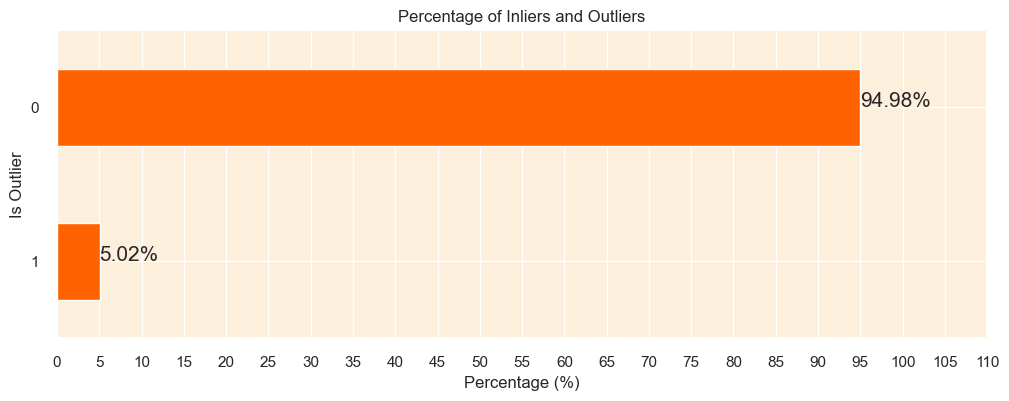

In [85]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

### Inference:
From the above plot, we can observe that about 5% of the customers have been identified as outliers in our dataset. This percentage seems to be a reasonable proportion, not too high to lose a significant amount of data, and not too low to retain potentially noisy data points. It suggests that our isolation forest algorithm has worked well in identifying a moderate percentage of outliers, which will be critical in refining our customer segmentation.

### Strategy:
Considering the nature of the project (customer segmentation using clustering), it is crucial to handle these outliers to prevent them from affecting the clusters' quality significantly. Therefore, I will separate these outliers for further analysis and remove them from our main dataset to prepare it for the clustering analysis.

Let's proceed with the following steps:

Separate the identified outliers for further analysis and save them as a separate file (optional).

Remove the outliers from the main dataset to prevent them from influencing the clustering process.

Drop the Outlier_Scores and Is_Outlier columns as they were auxiliary columns used for the outlier detection process.

In [86]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)
customer_data_cleaned

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4062,18280.0,277,1,45,180.6,180.6,10,0.0,0,9,1,0,0.0,180.6,0.0,0.0
4063,18281.0,180,1,54,80.82,80.82,7,0.0,6,10,1,0,0.0,80.82,0.0,0.0
4064,18282.0,7,3,98,176.6,58.866667,12,9.916667,4,13,1,1,0.333333,88.3,14.792674,-20.92
4065,18283.0,3,16,1355,2039.58,127.47375,262,0.465181,3,14,1,0,0.0,203.958,165.798738,22.319273


In [87]:
outliers_data

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635,-1,1
10,12357.0,33,1,2708,6207.67,6207.67,131,0.0,6,16,0,0,0.0,6207.67,0.0,0.0,-1,1
12,12359.0,7,6,1599,6182.98,1030.496667,214,1.296,3,12,0,2,0.333333,1030.496667,1137.566659,25.072571,-1,1
20,12370.0,51,4,2349,3421.94,855.485,142,1.884146,1,12,0,0,0.0,1140.646667,532.148517,-502.495,-1,1
26,12377.0,315,2,942,1548.12,774.06,71,0.52,0,9,0,0,0.0,774.06,321.677017,-454.92,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4154,18109.0,1,31,4212,7877.27,254.105484,120,0.817778,6,12,1,5,0.16129,605.943846,292.86308,57.616538,-1,1
4160,18118.0,10,31,2848,5564.63,179.504194,423,0.28357,4,12,1,5,0.16129,505.875455,247.406608,-1.253455,-1,1
4174,18139.0,17,6,5557,8438.34,1406.39,35,0.006329,0,14,1,2,0.333333,8438.34,0.0,0.0,-1,1
4235,18223.0,1,26,2891,6318.07,243.002692,118,1.20202,0,9,1,13,0.5,574.37,464.999472,14.670545,-1,1


### Correlation Analysis
Before we proceed to KMeans clustering, it's essential to check the correlation between features in our dataset. The presence of multicollinearity, where features are highly correlated, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, as the features do not provide unique information. This could lead to clusters that are not well-separated and meaningful.

If we identify multicollinearity, we can utilize dimensionality reduction techniques like PCA. These techniques help in neutralizing the effect of multicollinearity by transforming the correlated features into a new set of uncorrelated variables, preserving most of the original data's variance. This step not only enhances the quality of clusters formed but also makes the clustering process more computationally efficient.

In [88]:
# Reset background style
sns.set_style('whitegrid')

In [89]:
# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()
corr

,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
Days_Since_Last_Purchase,1.000000,-0.371592,-0.330702,-0.341584,-0.072896,-0.339963,-0.100666,-0.004100,-0.006495,-0.017133,-0.211158,-0.026638,-0.145418,-0.299944,-0.002021
Total_Transactions,-0.371592,1.000000,0.708811,0.797505,-0.042095,0.571302,0.003775,0.004121,-0.036954,0.045754,0.670681,0.219269,0.200892,0.473468,0.029460
Total_Products_Purchased,-0.330702,0.708811,1.000000,0.876570,0.323771,0.559603,-0.012542,-0.012637,-0.040086,0.019127,0.406441,0.081782,0.497354,0.554129,0.033508
Total_Spend,-0.341584,0.797505,0.876570,1.000000,0.361362,0.585792,-0.040368,-0.007847,-0.047901,0.015515,0.471069,0.099826,0.562878,0.635740,0.033920
Average_Transaction_Value,-0.072896,-0.042095,0.323771,0.361362,1.000000,0.185055,-0.104315,-0.033597,-0.033192,-0.094725,-0.114725,-0.186781,0.880774,0.246800,-0.001813
Unique_Products_Purchased,-0.339963,0.571302,0.559603,0.585792,0.185055,1.000000,-0.135471,0.072288,0.083352,0.059837,0.316543,0.056738,0.323476,0.416160,0.034563
Average_Days_Between_Purchases,-0.100666,0.003775,-0.012542,-0.040368,-0.104315,-0.135471,1.000000,-0.042447,-0.068656,0.027377,-0.002068,0.032313,-0.116819,0.023167,0.030229
Day_Of_Week,-0.004100,0.004121,-0.012637,-0.007847,-0.033597,0.072288,-0.042447,1.000000,0.070061,0.039006,-0.036479,-0.051480,-0.022515,-0.000453,-0.012321
Hour,-0.006495,-0.036954,-0.040086,-0.047901,-0.033192,0.083352,-0.068656,0.070061,1.000000,0.056982,-0.036410,-0.035248,-0.028020,-0.033758,0.006795
Is_UK,-0.017133,0.045754,0.019127,0.015515,-0.094725,0.059837,0.027377,0.039006,0.056982,1.000000,0.005567,-0.027441,-0.055582,0.019443,0.010935


D:\Anacondo\Lib\site-packages\seaborn\matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



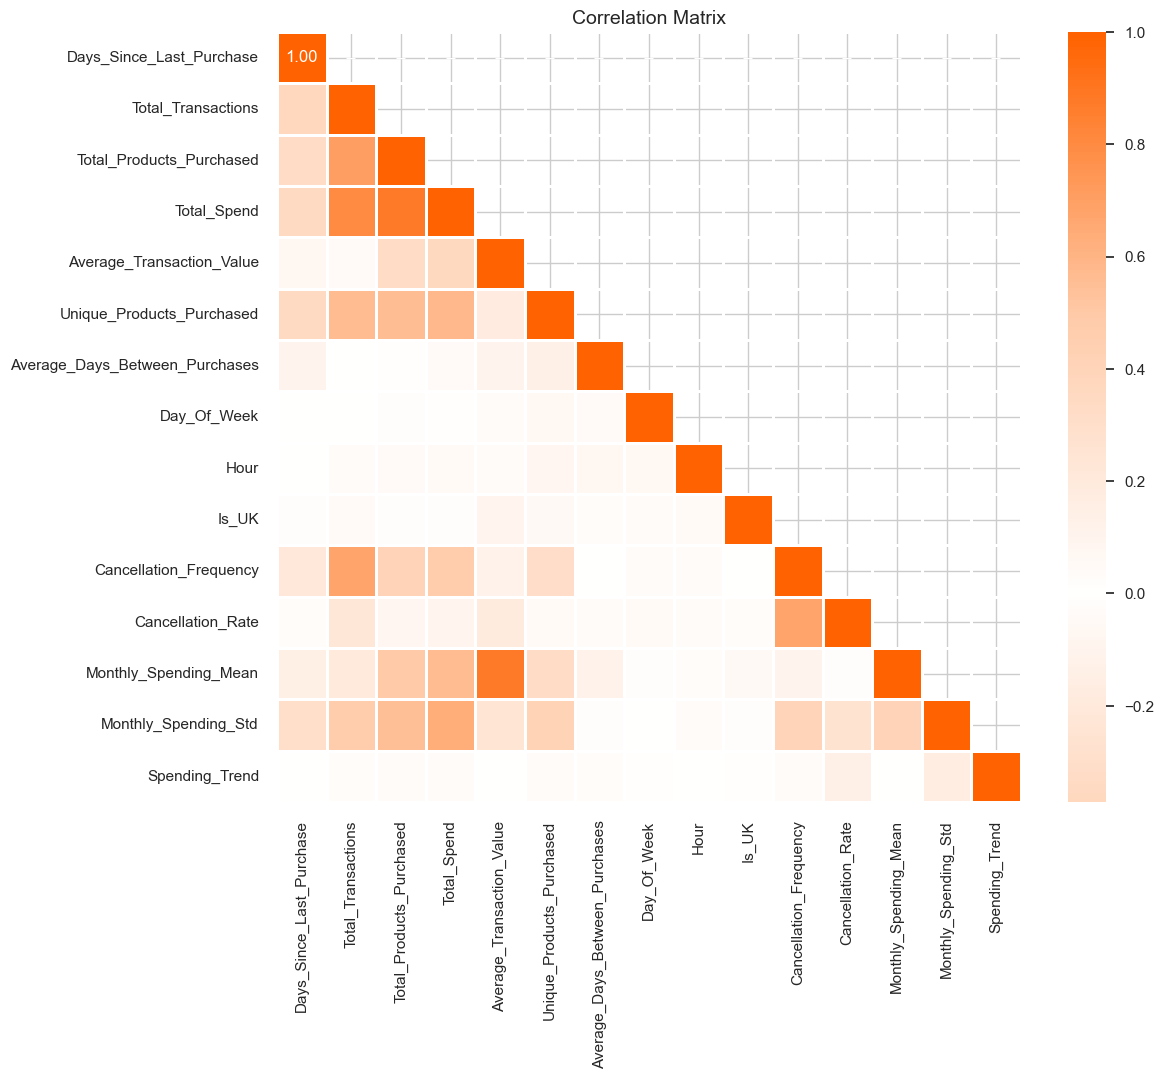

In [90]:
# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Create a mask to only show the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

### Inference:
Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

* Monthly_Spending_Mean and Average_Transaction_Value;
* Total_Spend and Total_Products_Purchased;
* Total_Transactions and Total_Spend;
* Cancellation_Rate and Cancellation_Frequency;
* Total_Transactions and Total_Products_Purchased

These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

# Feature Scaling
For K-means Clustering: K-means relies heavily on the concept of 'distance' between data points to form clusters. When features are not on a similar scale, features with larger values can disproportionately influence the clustering outcome, potentially leading to incorrect groupings.

For PCA: PCA aims to find the directions where the data varies the most. When features are not scaled, those with larger values might dominate these components, not accurately reflecting the underlying patterns in the data.

Methodology:
Therefore, to ensure a balanced influence on the model and to reveal the true patterns in the data, I am going to standardize our data, meaning transforming the features to have a mean of 0 and a standard deviation of 1. However, not all features require scaling. Here are the exceptions and the reasons why they are excluded:

CustomerID: This feature is just an identifier for the customers and does not contain any meaningful information for clustering.
Is_UK: This is a binary feature indicating whether the customer is from the UK or not. Since it already takes a value of 0 or 1, scaling it won't make any significant difference.
Day_Of_Week: This feature represents the most frequent day of the week that the customer made transactions. Since it's a categorical feature represented by integers (1 to 7), scaling it would not be necessary.

In [91]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)
columns_to_scale 

Index(['Average_Days_Between_Purchases', 'Average_Transaction_Value',
       'Cancellation_Frequency', 'Cancellation_Rate',
       'Days_Since_Last_Purchase', 'Hour', 'Monthly_Spending_Mean',
       'Monthly_Spending_Std', 'Spending_Trend', 'Total_Products_Purchased',
       'Total_Spend', 'Total_Transactions', 'Unique_Products_Purchased'],
      dtype='object')

In [92]:
# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.349441,-0.478608,-0.747281,-0.789046,-1.320137,-0.898051,-0.327680,1,-1.089953,1,0.337826,2.163776,-1.334558,-0.713357,0.088012
1,12347.0,-0.902177,0.658632,1.952814,2.228635,1.538983,0.789149,-0.127983,1,0.644844,0,-0.540089,-0.590930,0.990507,1.257394,0.114857
2,12348.0,-0.167291,-0.023712,1.814404,0.217249,0.348348,-0.567228,0.750199,3,2.813340,0,-0.540089,-0.590930,0.022271,0.464663,-0.515677
3,12349.0,-0.741106,-0.706056,-0.055231,0.231469,5.448116,0.276372,-0.327680,0,-1.523653,0,-0.540089,-0.590930,4.169452,-0.713357,0.088012
4,12350.0,2.198437,-0.706056,-0.531976,-0.582919,0.046933,-0.649934,-0.327680,2,1.512242,0,-0.540089,-0.590930,-0.222843,-0.713357,0.088012


# Dimensionality Reduction

Why We Need Dimensionality Reduction?

Multicollinearity Detected: In the previous steps, we identified that our dataset contains multicollinear features. Dimensionality reduction can help us remove redundant information and alleviate the multicollinearity issue.


Better Clustering with K-means: Since K-means is a distance-based algorithm, having a large number of features can sometimes dilute the meaningful underlying patterns in the data. By reducing the dimensionality, we can help K-means to find more compact and well-separated clusters.

Noise Reduction: By focusing only on the most important features, we can potentially remove noise in the data, leading to more accurate and stab e cluste.ent.ient.

Enhanced Visualization: In the context of customer segmentation, being able to visualize customer groups in two or three dimensions can provide intuitive insights. Dimensionality reduction techniques can facilitate this by reducing the data to a few principal components which can be plotted easily. 

Improved Computational Efficiency: Reducing the number of features can speed up the computation time during the modeling process, making our clustering algorithm more efficient.

PCA is an excellent starting point because it works well in capturing linear relationships in the data, which is particularly relevant given the multicollinearity we identified in our dataset. It allows us to reduce the number of features in our dataset while still retaining a significant amount of the information, thus making our clustering analysis potentially more accurate and interpretable. Moreover, it is computationally efficient, which means it won't significantly increase the processing time.

However, it's essential to note that we are keeping our options open. After applying PCA, if we find that the first few components do not capture a significant amount of variance, indicating a loss of vital information, we might consider exploring other non-linear methods. These methods can potentially provide a more nuanced approach to dimensionality reduction, capturing complex patterns that PCA might miss, albeit at the cost of increased computational time and complexity.

In [93]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

In [94]:
# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
cumulative_explained_variance

array([0.27212604, 0.48201607, 0.60581953, 0.68087695, 0.74759829,
       0.80759013, 0.86145805, 0.90462279, 0.93374325, 0.96232594,
       0.97815979, 0.98654793, 0.99151999, 0.9958468 , 1.        ])

In [95]:
# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

In [96]:
# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

D:\Anacondo\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



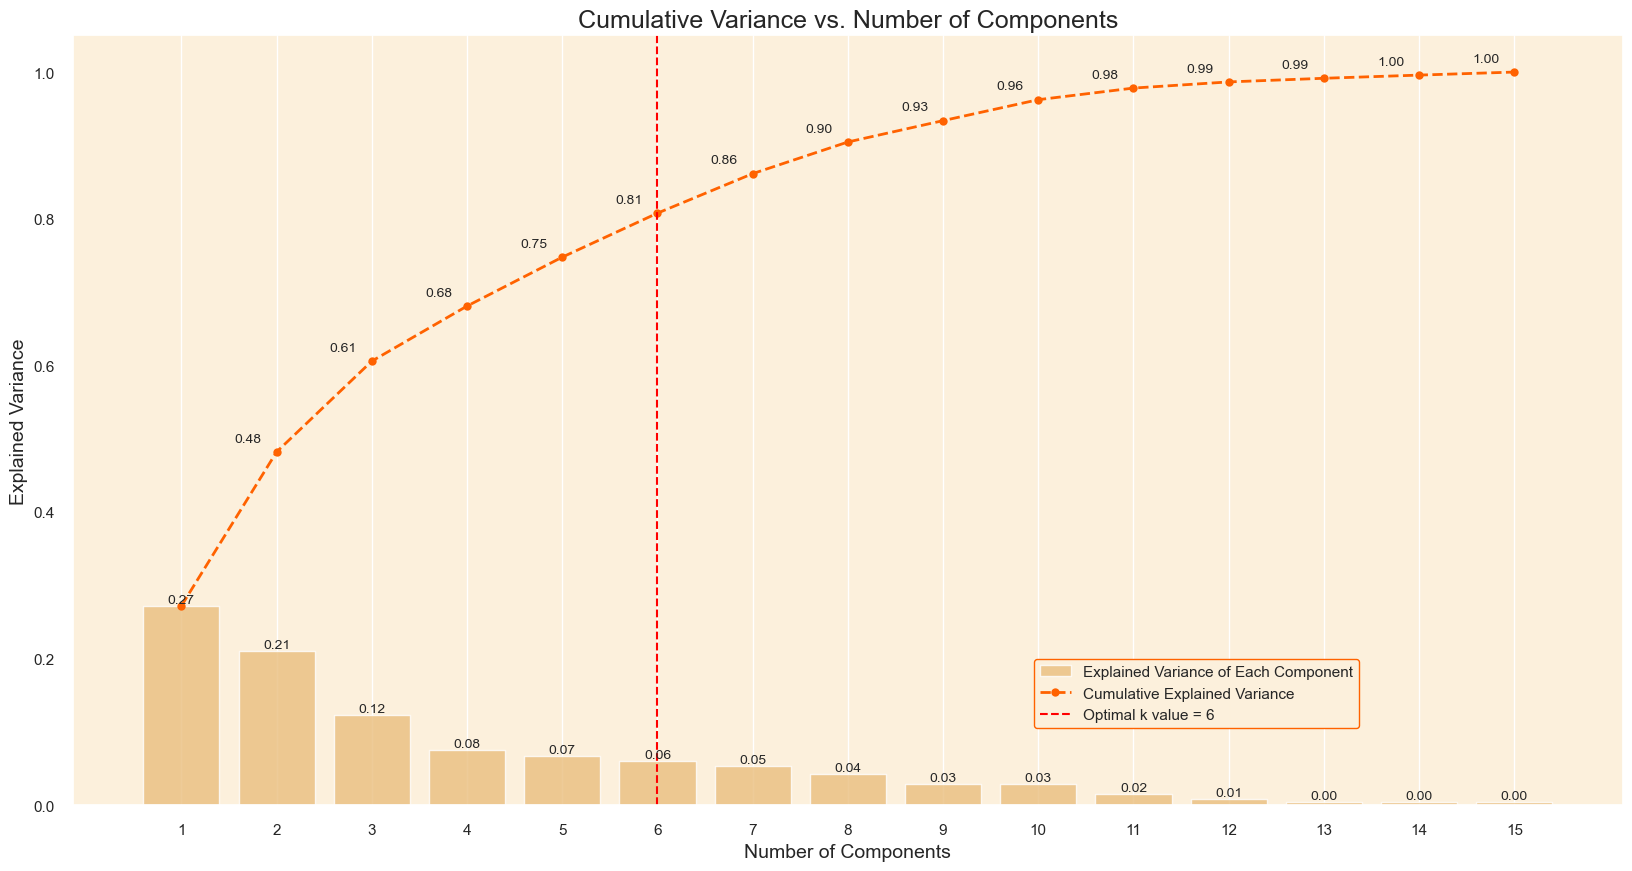

In [115]:
# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

### Conclusion
The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

The first component explains approximately 28% of the variance.

The first two components together explain about 49% of the variance.

The first three components explain approximately 61% of the variance, and so on.

To choose the optimal number of components, we generally look for a point where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the "elbow point" in the curve.

From the plot, we can see that the increase in cumulative variance starts to slow down after the 6th component (which captures about 81% of the total variance).

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [97]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

In [98]:
# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)
customer_data_pca

array([[-2.08337504, -1.76800676,  2.23973621,  1.5718728 , -0.20540584,
        -1.90990871],
       [ 3.27741083, -1.39637484, -1.90326136, -0.72815238, -0.20337926,
         0.73249234],
       [ 0.60481642,  0.58342516, -0.69869014, -0.58627364, -0.79778624,
         2.10093435],
       ...,
       [-1.19175527,  1.34028424,  1.91793816,  0.01688845,  0.4822738 ,
         0.37827225],
       [ 2.48496437,  0.81384907,  0.70866453, -2.5364205 , -1.3117611 ,
         0.74366374],
       [ 1.51970811, -0.60364695, -2.58481181, -0.55933589,  0.94280039,
        -1.50599067]])

In [99]:
# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

customer_data_pca

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.083375,-1.768007,2.239736,1.571873,-0.205406,-1.909909
12347.0,3.277411,-1.396375,-1.903261,-0.728152,-0.203379,0.732492
12348.0,0.604816,0.583425,-0.698690,-0.586274,-0.797786,2.100934
12349.0,1.859755,-2.686949,-5.743642,1.852748,1.224039,-0.906455
12350.0,-1.980281,-0.517483,-0.738159,0.341690,-1.456411,-0.166892
...,...,...,...,...,...,...
18280.0,-2.161850,-2.662538,-0.194745,0.352192,0.279669,-1.375986
18281.0,-2.322982,3.346201,0.397159,0.066420,0.566489,-0.967701
18282.0,-1.191755,1.340284,1.917938,0.016888,0.482274,0.378272


In [100]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

In [101]:
# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217658,-0.012362,-0.056397,0.320365,-0.173475,-0.409168
Total_Transactions,0.384825,0.014801,0.239014,-0.207519,-0.040147,-0.068993
Total_Products_Purchased,0.410634,0.006261,-0.060064,-0.128228,0.030308,-0.039945
Total_Spend,0.438209,0.009215,-0.057890,-0.090352,0.017855,-0.060148
Average_Transaction_Value,0.182304,-0.015350,-0.567437,0.246997,0.079344,-0.037116
Unique_Products_Purchased,0.328470,0.062039,-0.012940,-0.216603,-0.237175,0.071823
Average_Days_Between_Purchases,-0.023565,-0.035869,0.129975,-0.190807,0.706365,0.285206
Day_Of_Week,-0.021718,0.994359,0.016915,0.047119,0.071394,-0.041782
Hour,-0.018554,0.056121,-0.011127,-0.139575,-0.617301,0.493574
Is_UK,0.001491,0.006642,0.011515,-0.021984,-0.008279,0.014105


# K-Means Clustering

K-Means:
K-Means is an unsupervised machine learning algorithm that clusters data into a specified number of groups (K) by minimizing the within-cluster sum-of-squares (WCSS), also known as inertia. The algorithm iteratively assigns each data point to the nearest centroid, then updates the centroids by calculating the mean of all assigned points. The process repeats until convergence or a stopping criterion is reached.

 Determining the Optimal Number of Clusters

 Elbow Method: The Elbow Method is a technique for identifying the ideal number of clusters in a dataset. It involves iterating through the data, generating clusters for various values of k. The k-means algorithm calculates the sum of squared distances between each data point and its assigned cluster centroid, known as the inertia or WCSS score. By plotting the inertia score against the k value, we create a graph that typically exhibits an elbow shape, hence the name "Elbow Method". The elbow point represents the k-value where the reduction in inertia achieved by increasing k becomes negligible, indicating the optimal stopping point for the number of clusters.  YellowBrick, an extension of the Scikit-Learn API, is renowned for its ability to rapidly generate insightful visualizations in the field of machine learning.
 od

In [102]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

In [103]:
# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)
km

KMeans(max_iter=100, n_init=10, random_state=0)

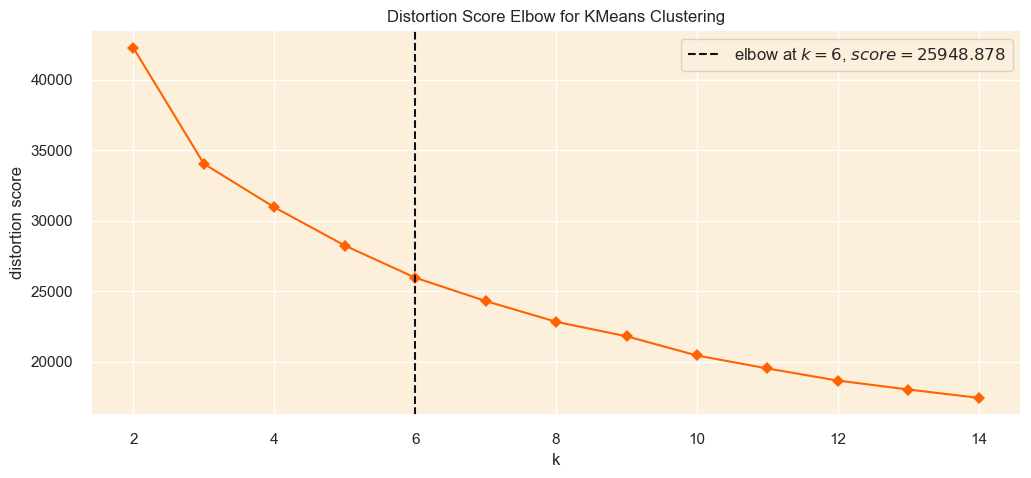

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [104]:
# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show()

### Optimal k Value: Elbow Method Insights

The optimal value of k for the KMeans clustering algorithm can be found at the elbow point. Using the YellowBrick library for the Elbow method, we observe that the suggested optimal k value is 5. However, we don't have a very distinct elbow point in this case, which is common in real-world data. From the plot, we can see that the inertia continues to decrease significantly up to k=5, indicating that the optimum value of k could be between 3 and 7. To choose the best k within this range, we can employ the silhouette analysis, another cluster quality evaluation method. Additionally, incorporating business insights can help determine a practical k value.

### Silhouette Method: 
The Silhouette Method is an approach to find the optimal number of clusters in a dataset by evaluating the consistency within clusters and their separation from other clusters. It computes the silhouette coefficient for each data point, which measures how similar a point is to its own cluster compared to other clusters.

I will initially choose a range of 2-6 for the number of clusters (k) based on the Elbow method from the previous section. Next, I will plot Silhouette scores for each k value to determine the one with the highest score.
Subsequently, to fine-tune the selection of the most appropriate k, I will generate Silhouette plots that visually display the silhouette coefficients for each data point within various clusters.

In [105]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

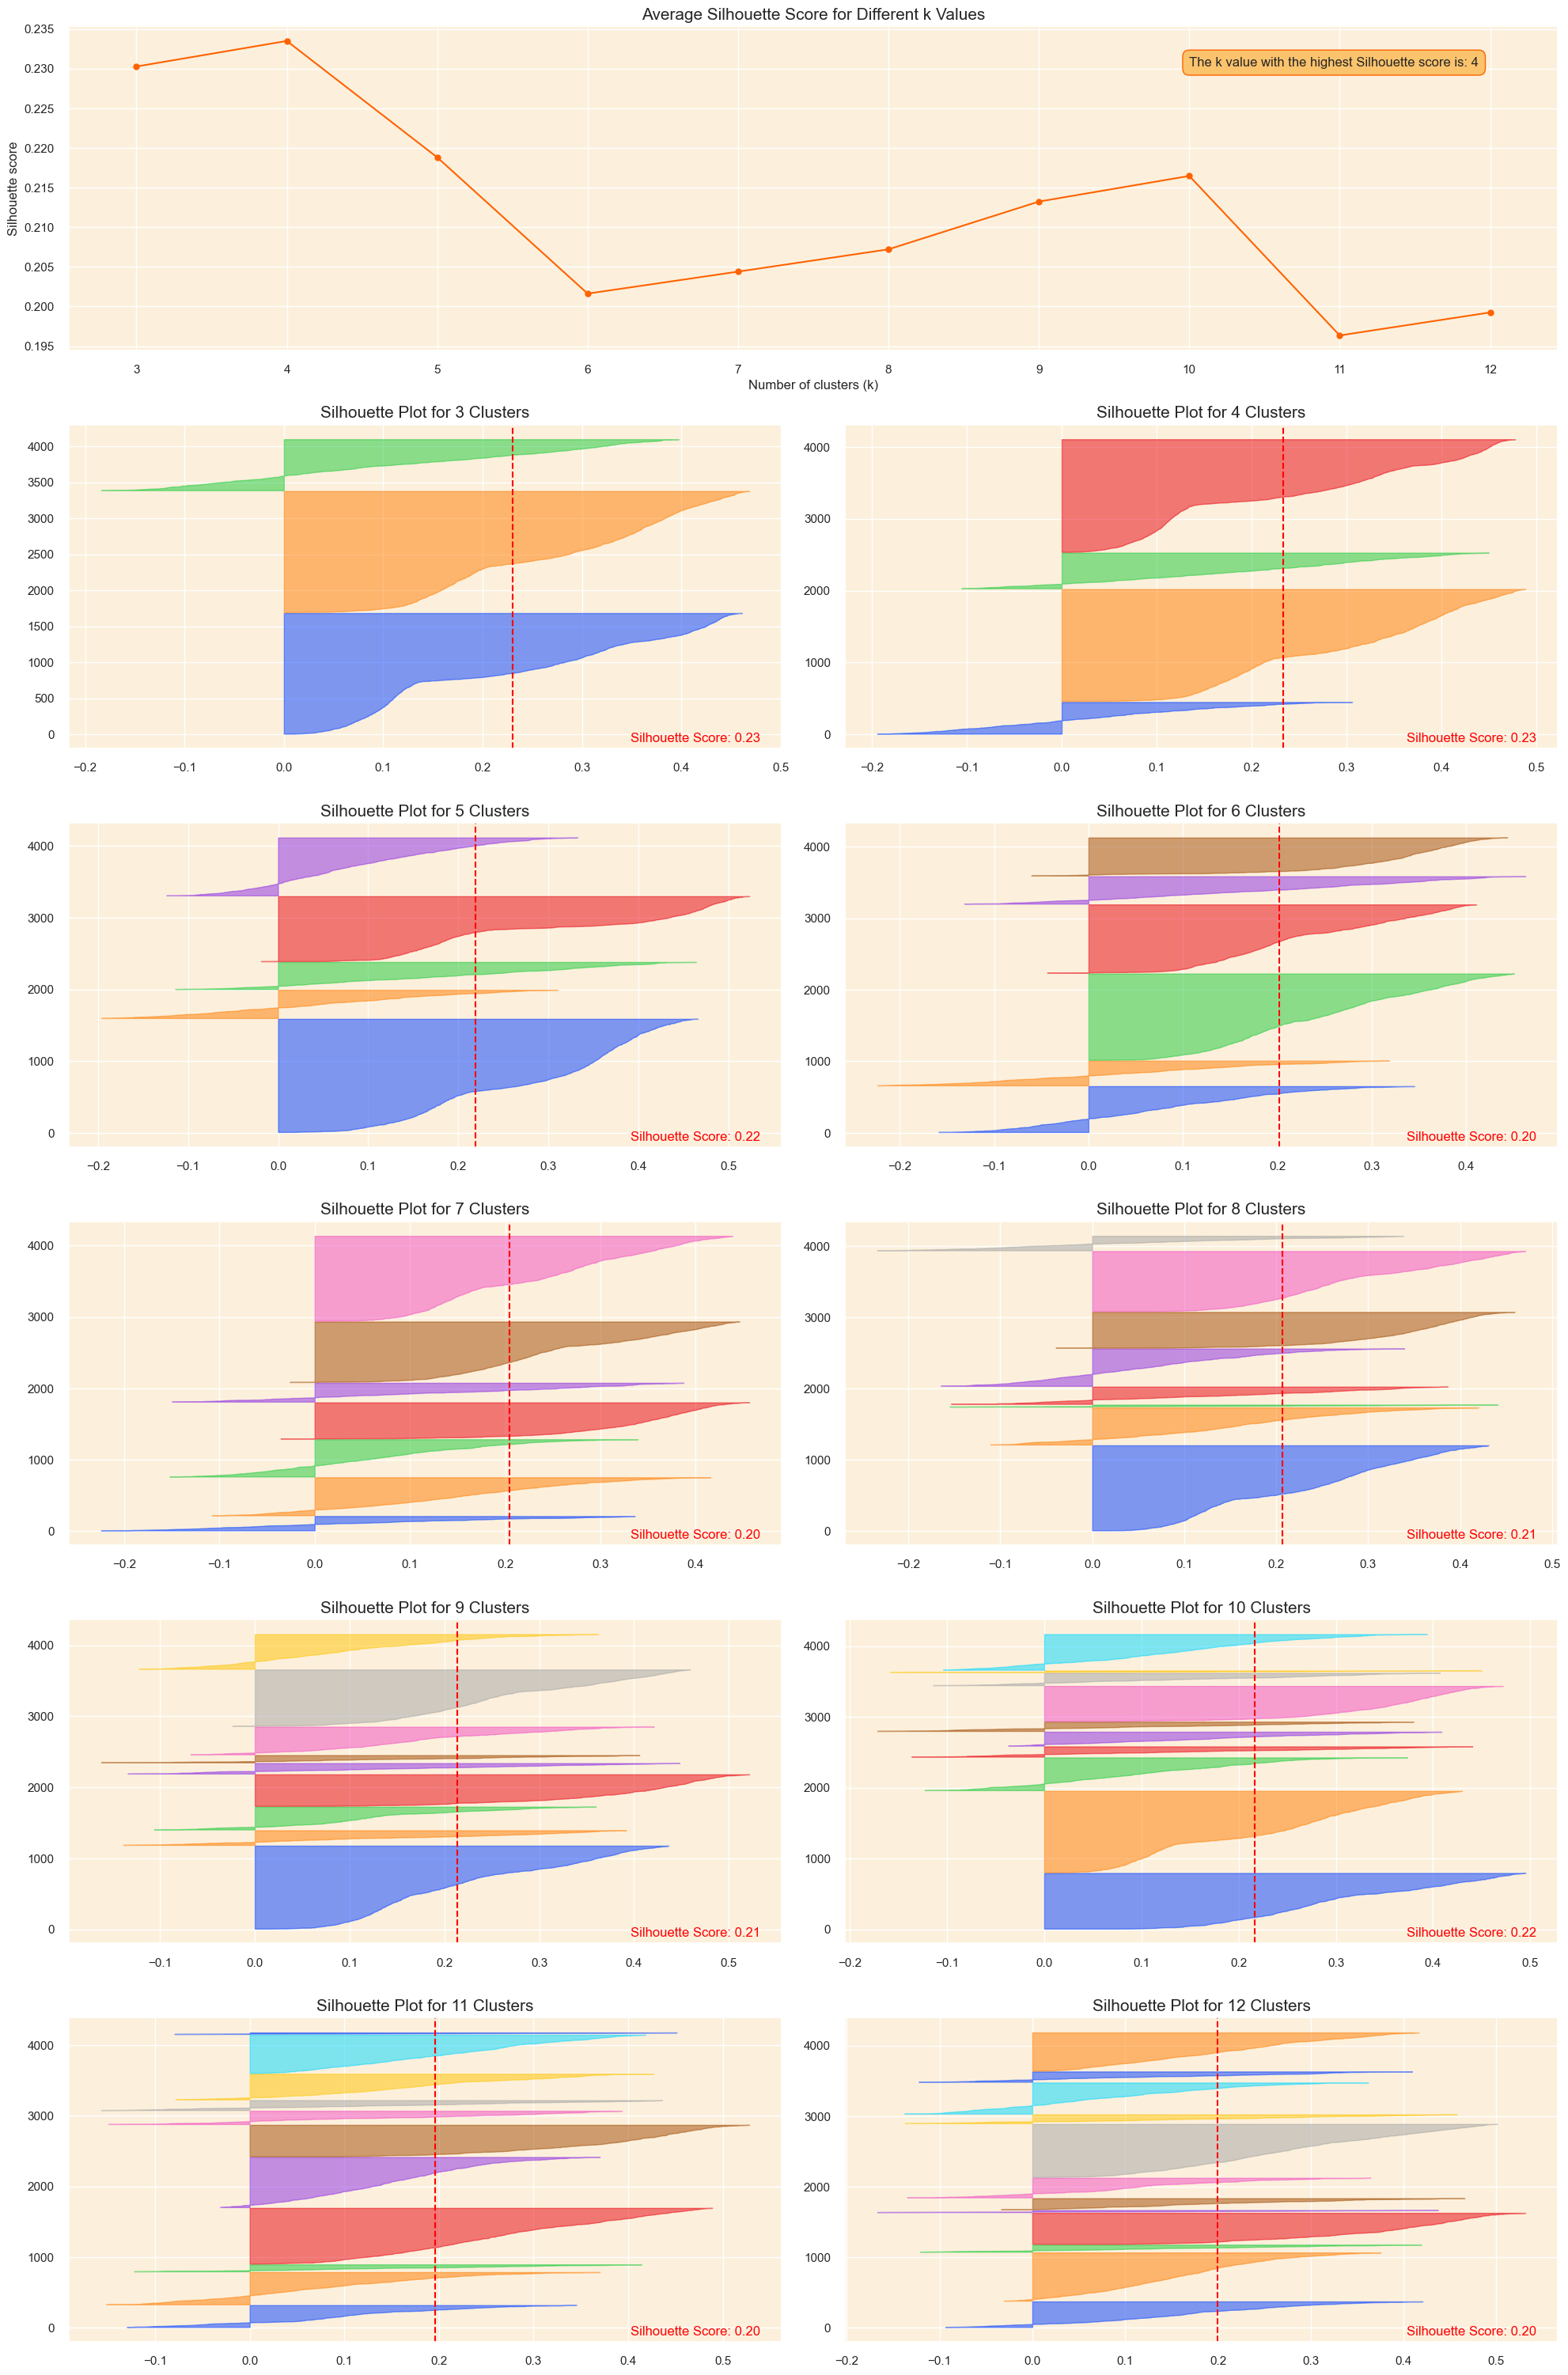

In [106]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

## Optimal k Value: Silhouette Method Insights
Based on above guidelines and after carefully considering the silhouette plots, it's clear that choosing ( k = 3 ) is the better option. This choice gives us clusters that are more evenly matched and well-defined, making our clustering solution stronger and more reliable.

# Clustering Model - K-means

In this step, I am going to apply the K-means clustering algorithm to segment customers into different clusters based on their purchasing behaviors and other characteristics, using the optimal number of clusters determined in the previous step.

It's important to note that the K-means algorithm might assign different labels to the clusters in each run. To address this, we have taken an additional step to swap the labels based on the frequency of samples in each cluster, ensuring a consistent label assignment across different runs.

In [107]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [108]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,2
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,2
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,2


#  Cluster Analysis and Profiling

 I am going to analyze the characteristics of each cluster to understand the distinct behaviors and preferences of different customer segments and also profile each cluster to identify the key traits that define the customers in each cluster.

# Histogram Chart Approach

In [109]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

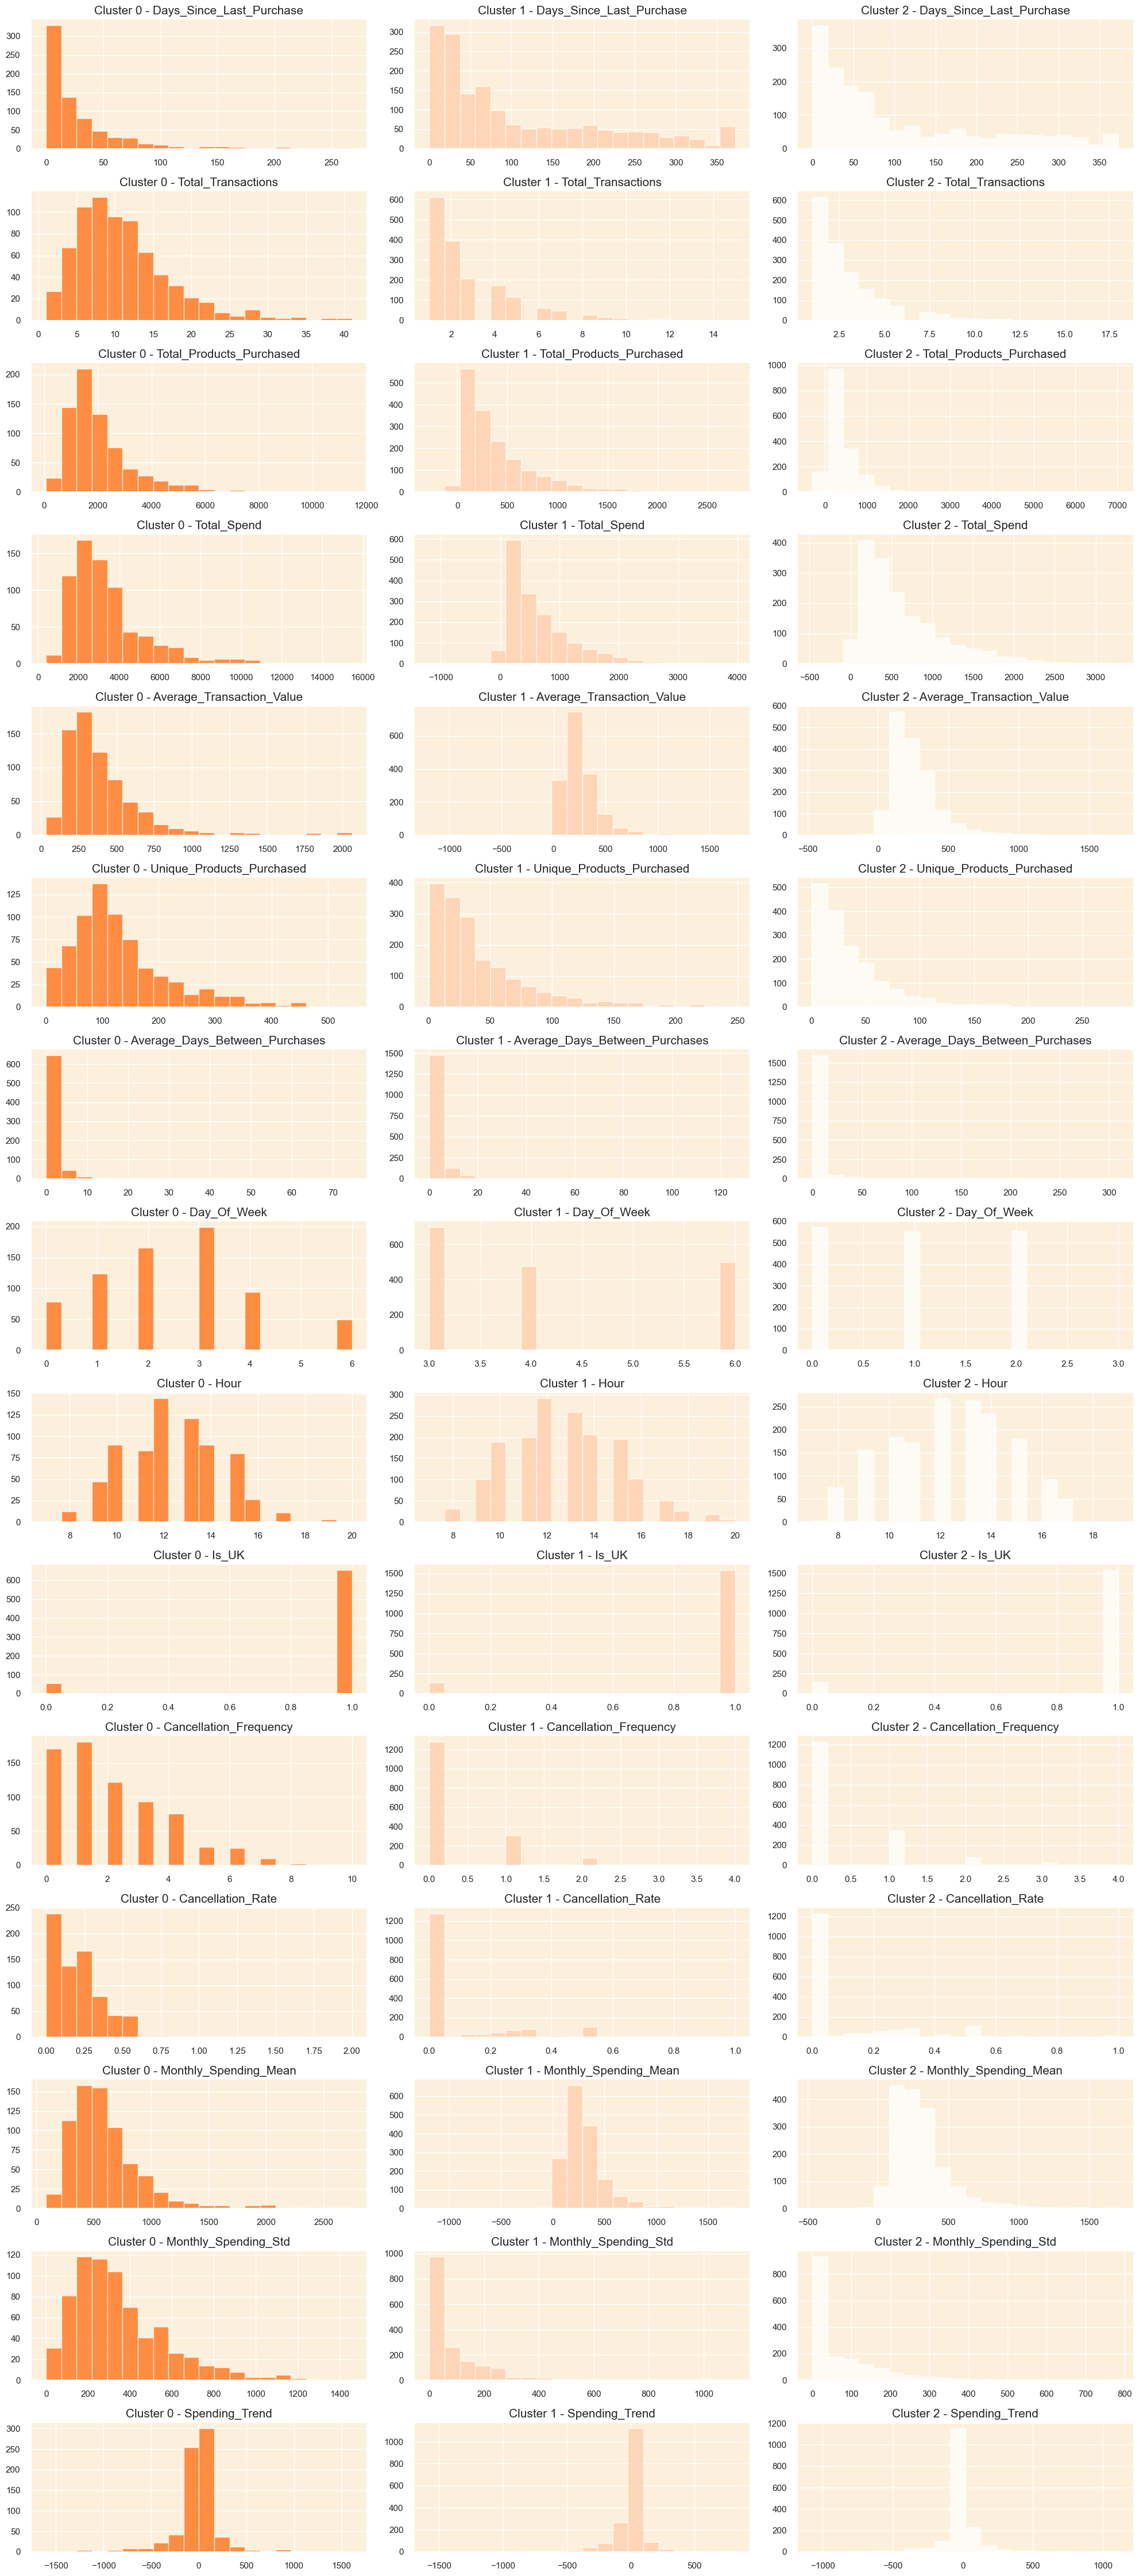

In [112]:
# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

# Clusters
## Casual Weekend Shoppers:

### Characteristics:
* Shop less frequently and spend less money
* Fewer transactions and fewer products purchase
* Prefer shopping on weeken
* Stable, low spending habits with minimal monthly fluctuati
* Rarely cancel transactions.
* Lower average transaction value.

### Recommendations:
* Target these customers with promotions and recommendations on weekends.
* Focus on engagement strategies to increase their shopping frequency.


## Occasional Big Spenders:
### Characteristics:* Infrequent shoppers but spend a significant amount when they do shop.
* High spending trend, with increasing spend over time.
* Prefer shopping late in the day, mostly residing in the UK.
* Moderate number of cancellations, likely due to higher spending.
* High average transaction value, indicating a preference for premium products.

### Recommendations 
* Tailor marketing messages to busy professionals who prefer shopping in the evenings.
* Highlight premium products and offer exclusive deals to encourage more frequent purchases.



###  Eager Early-Bird Shoppers:
### Characteristics:
* High total spend and purchase a wide variety of unique products.
* 	Frequent transactions with a high cancellation frequency and rate
   •	Low average time between purchases, shopping early in the da
* 
•	High variability in monthly spendi
* 
•	Decreasing spending trend despite high overall spe

### Recommendations:
* Offer early bird specials and morning promotions to align with their shopping habits.
* 	Implement a loyalty program to encourage consistent spending and reduce cancellations.
nd.


###  Eager Early-Bird Shoppers:
### Characteristics:
* High total spend and purchase a wide variety of unique products.
* Frequent transactions with a high cancellation frequency and rate.
* Low average time between purchases, shopping early in the day.
* High variability in monthly spending.
* 	Decreasing spending trend despite high overall spnd.e

### Recommendations:
* Offer early bird specials and morning promotions to align with their shopping habits.
*	Implement a loyalty program to encourage consistent spending and reduce cancellationsd.


###  Eager Early-Bird Shoppers:
### Characteristics:
* High total spend and purchase a wide variety of unique products.
* Frequent transactions with a high cancellation frequency and rate.
* Low average time between purchases, shopping early in the day.
* High variability in monthly spending.
* 	Decreasing spending trend despite high overall spend.

### Recommendations:
* Offer early bird specials and morning promotions to align with their shopping habits.
*	Implement a loyalty program to encourage consistent spending and reduce cancellationsd.
